### Importing Libraries

In [1]:
import pandas as pd
import datetime as dt
import seaborn as sns
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
import pmdarima as pm
from fbprophet import Prophet

%matplotlib inline

### Importing Stockprices Dataset

In [2]:
dateparse = lambda x: pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S', errors = 'coerce')
Stock = pd.read_csv('prices.csv',parse_dates=['date'], date_parser=dateparse)
pd.set_option('display.max_columns', None)
Stock.head(5)

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


### Dataset Profiling

In [3]:
print("Dataset dimension :", Stock.ndim)
print("Dataset shape :", Stock.shape)
print("Dataset size :", Stock.size)

Dataset dimension : 2
Dataset shape : (851264, 7)
Dataset size : 5958848


In [4]:
Stock_types = Stock.dtypes.reset_index()
Stock_types.columns = ['Features','Data Types']
Stock_types

,Features,Data Types
0,date,datetime64[ns]
1,symbol,object
2,open,float64
3,close,float64
4,low,float64
5,high,float64
6,volume,float64


### Dataset Inspection

### Dataset Missing Value and Blank Value Check

In [5]:
miss_data = Stock.isnull().sum().reset_index()
miss_data.columns = ['Features','Missing Values']
blank_data = Stock.apply(lambda x: x == ' ').sum().reset_index()
blank_data.columns = ['Features','Blank Values']
merged_data = pd.merge(miss_data,blank_data, on=['Features'])
merged_data['Filling Factor'] = (Stock.shape[0]-miss_data['Missing Values'] + Stock.shape[0]-blank_data['Blank Values'])/Stock.shape[0]*50
merged_data.sort_values(by='Filling Factor',ascending=True)

,Features,Missing Values,Blank Values,Filling Factor
0,date,0,0,100.0
1,symbol,0,0,100.0
2,open,0,0,100.0
3,close,0,0,100.0
4,low,0,0,100.0
5,high,0,0,100.0
6,volume,0,0,100.0


### Checking Symbol Unique Value

In [6]:
sy_count = Stock['symbol'].value_counts().reset_index()
sy_count.columns = ['symbol','Total Counts']
sy_count.sort_values(by='Total Counts',ascending=False)
sy_count.head(10)

,symbol,Total Counts
0,KSU,1762
1,NOC,1762
2,ORCL,1762
3,OMC,1762
4,OKE,1762
5,O,1762
6,NWL,1762
7,NVDA,1762
8,NUE,1762
9,NTRS,1762


### Sampling 2 Companies Stockprices For Analysis

Amazon and NVIDIA each of these companies are labeled as follows in dataset:
 - AMZN
 - NVDA

### Creating New Dataframe based on the Companies Chosen

### Amazon

In [7]:
AMZN = Stock.loc[Stock['symbol'] == 'AMZN']
AMZN

,date,symbol,open,close,low,high,volume
284,2010-01-04,AMZN,136.250000,133.899994,133.139999,136.610001,7599900.0
751,2010-01-05,AMZN,133.429993,134.690002,131.809998,135.479996,8851900.0
1219,2010-01-06,AMZN,134.600006,132.250000,131.649994,134.729996,7178800.0
1687,2010-01-07,AMZN,132.009995,130.000000,128.800003,132.320007,11030200.0
2155,2010-01-08,AMZN,130.559998,133.520004,129.029999,133.679993,9830500.0
...,...,...,...,...,...,...,...
848799,2016-12-23,AMZN,764.549988,760.590027,757.989990,766.500000,1976900.0
849299,2016-12-27,AMZN,763.400024,771.400024,761.200012,774.650024,2627400.0
849799,2016-12-28,AMZN,776.250000,772.130005,770.500000,780.000000,3279100.0
850299,2016-12-29,AMZN,772.400024,765.150024,760.849976,773.400024,3153500.0


### NVIDIA

In [8]:
NVDA = Stock.loc[Stock['symbol'] == 'NVDA']
NVDA

,date,symbol,open,close,low,high,volume
566,2010-01-04,NVDA,18.510000,18.490000,18.110001,18.620001,20005100.0
1034,2010-01-05,NVDA,18.420000,18.760000,18.420000,18.959999,18216200.0
1502,2010-01-06,NVDA,18.750000,18.879999,18.570000,18.920000,16229200.0
1970,2010-01-07,NVDA,18.780001,18.510000,18.370001,18.860001,13694800.0
2438,2010-01-08,NVDA,18.360001,18.549999,18.250000,18.680000,11954200.0
...,...,...,...,...,...,...,...
849100,2016-12-23,NVDA,106.379997,109.779999,106.269997,109.839996,16168700.0
849600,2016-12-27,NVDA,112.059998,117.320000,111.220001,117.360001,29669800.0
850100,2016-12-28,NVDA,119.599998,109.250000,108.690002,119.930000,57082600.0
850600,2016-12-29,NVDA,104.900002,111.430000,102.800003,111.489998,54036800.0


### Dataset Data Range Date

### Amazon

In [9]:
print("Amazon Minimum date value : {}".format(AMZN['date'].min()))
print("Amazon Maximum date value : {}".format(AMZN['date'].max()))

Amazon Minimum date value : 2010-01-04 00:00:00
Amazon Maximum date value : 2016-12-30 00:00:00


### NVIDIA

In [10]:
print("Nvidia Minimum date value : {}".format(NVDA['date'].min()))
print("Nvidia Maximum date value : {}".format(NVDA['date'].max()))

Nvidia Minimum date value : 2010-01-04 00:00:00
Nvidia Maximum date value : 2016-12-30 00:00:00


### Exploratory Data Analysis

### Amazon 

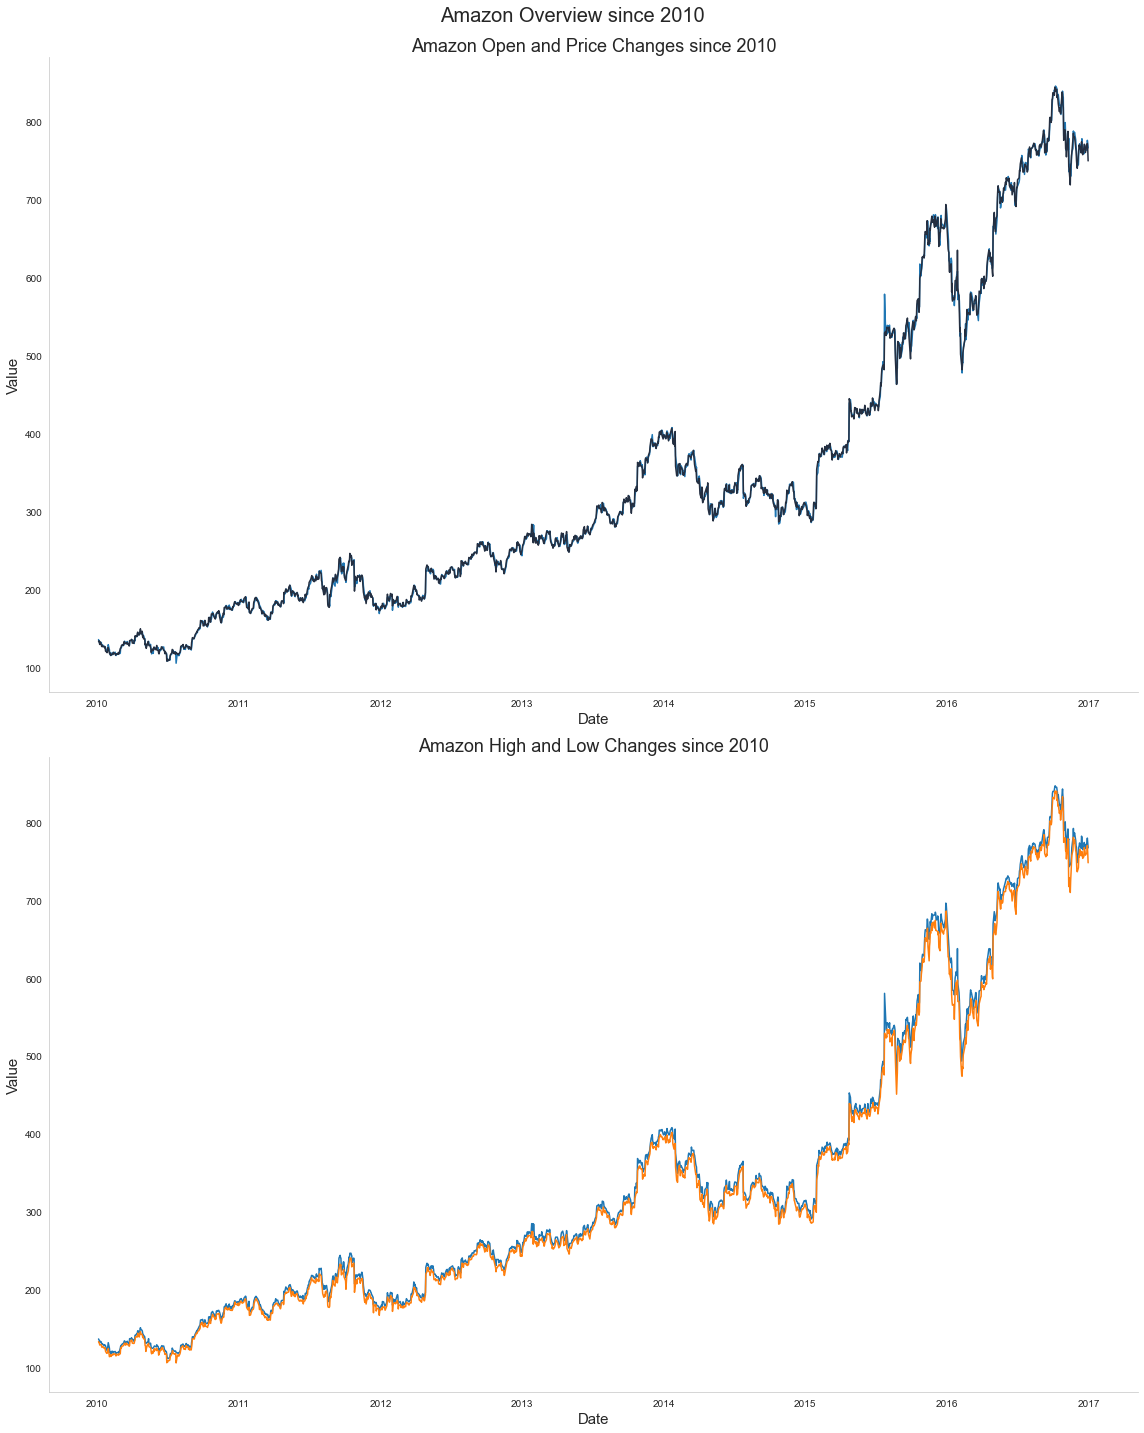

In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(16,20))
fig.suptitle("Amazon Overview since 2010", fontsize=20, verticalalignment="bottom")
 
#Plot 1
colors1 = ['#FF9A00','#242F41']

ax1=sns.lineplot(data=AMZN, x='date',y='open',ax=ax1)
ax1=sns.lineplot(data=AMZN, x='date',y='close',ax=ax1, color=colors1[1])
ax1.set_ylabel('Value',fontsize=15,fontweight='normal')    
ax1.set_xlabel('Date',fontsize=15,fontweight='normal') 
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_title('Amazon Open and Price Changes since 2010',fontsize=18, fontweight='normal')

#Plot 2
ax2=sns.lineplot(data=AMZN, x='date',y='high',ax=ax2)
ax2=sns.lineplot(data=AMZN, x='date',y='low',ax=ax2)
ax2.set_ylabel('Value',fontsize=15,fontweight='normal')    
ax2.set_xlabel('Date',fontsize=15,fontweight='normal') 
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_title('Amazon High and Low Changes since 2010',fontsize=18, fontweight='normal')

plt.tight_layout()

Text(0.5, 1.0, 'Amazon Volume Changes since 2010')

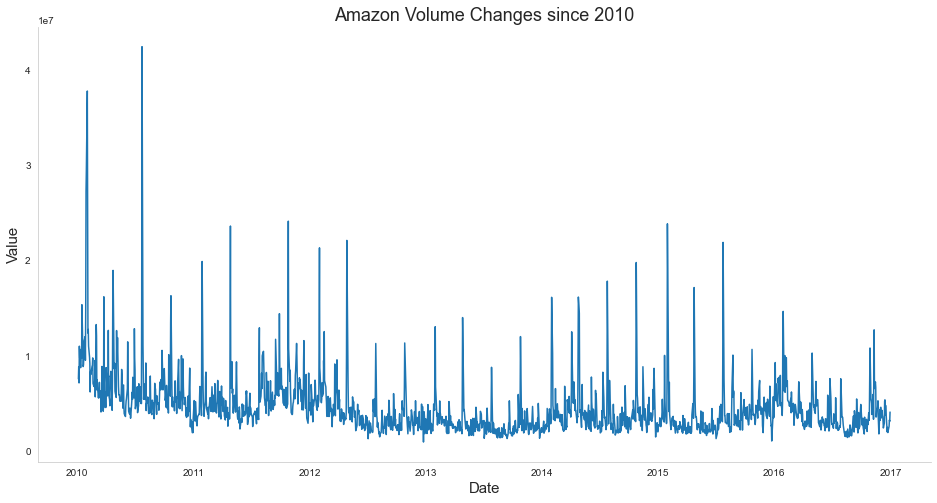

In [12]:
fig3=plt.figure(figsize=(16,8))
ax3=sns.lineplot(data=AMZN, x='date',y='volume')
ax3.set_ylabel('Value',fontsize=15,fontweight='normal')    
ax3.set_xlabel('Date',fontsize=15,fontweight='normal') 
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.set_title('Amazon Volume Changes since 2010',fontsize=18, fontweight='normal')

### Amazon Numerical Feature Plot

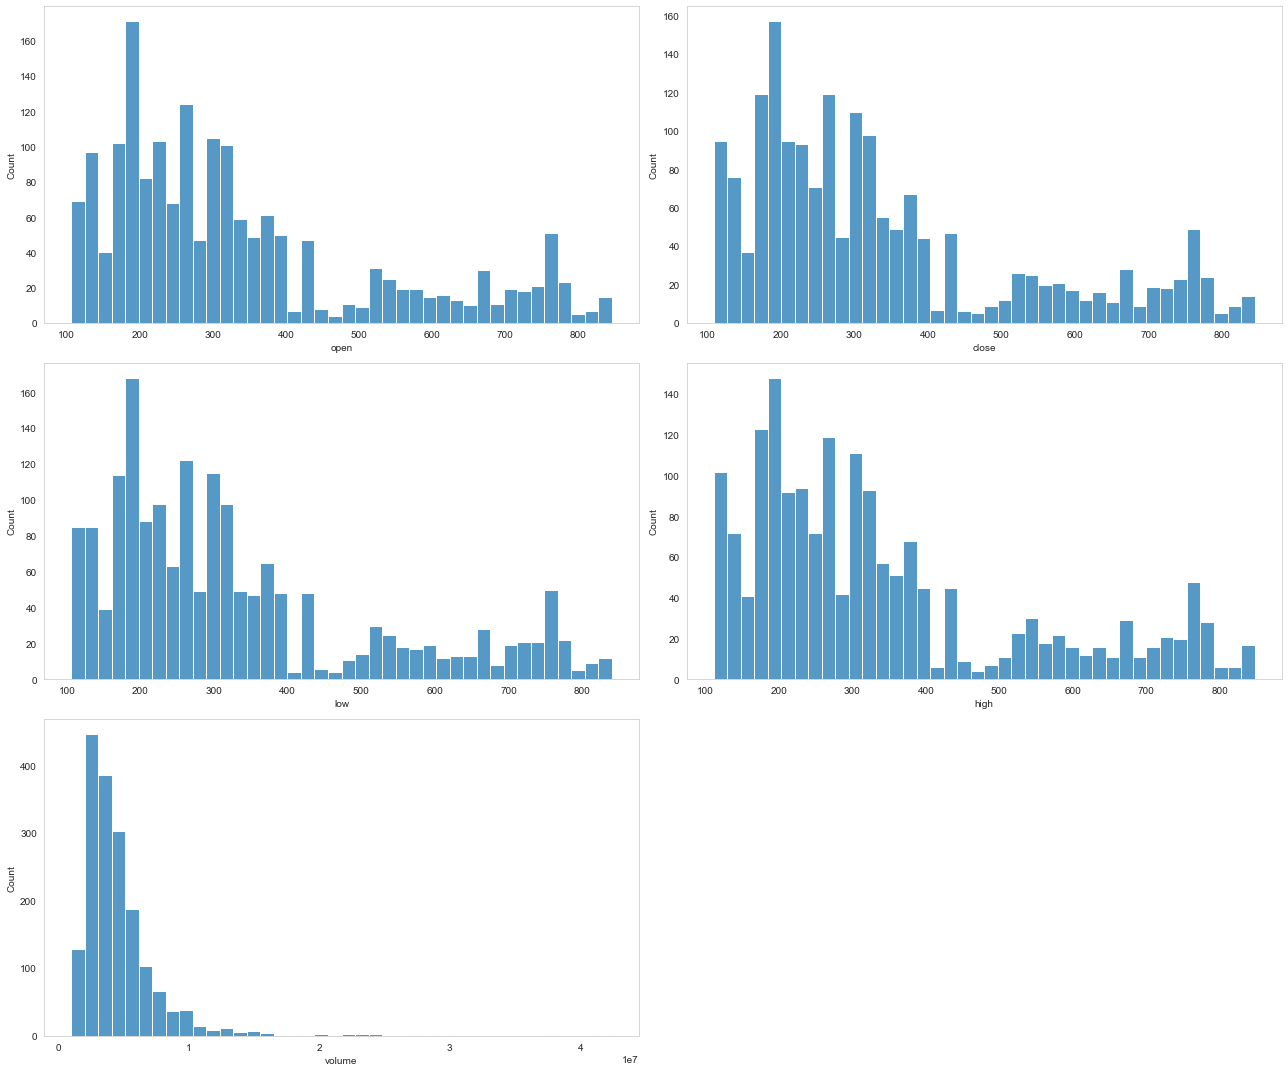

In [13]:
AMZN_num = AMZN[['open','close','low','high','volume']]

plt.figure(figsize=(18, 15))
for i in range(0, len(list(AMZN_num))):
    plt.subplot(3, 2, i+1)
    sns.histplot(x=AMZN[list(AMZN_num)[i]],bins = 40)
    plt.tight_layout()

### Amazon Outliers Checking

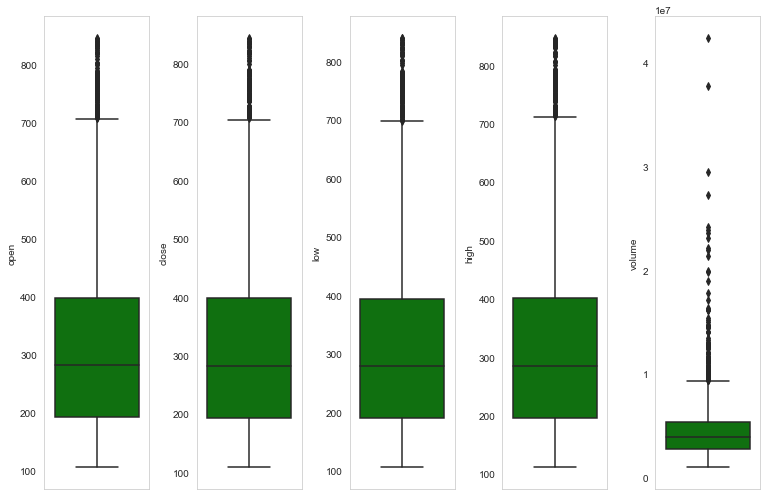

In [14]:
plt.figure(figsize=(15, 7))
for i in range(0, len(list(AMZN_num))):
    plt.subplot(1, 7, i+1)
    sns.boxplot(y=AMZN[list(AMZN_num)[i]],color='green',orient='v')
    plt.tight_layout()

### Nvidia 

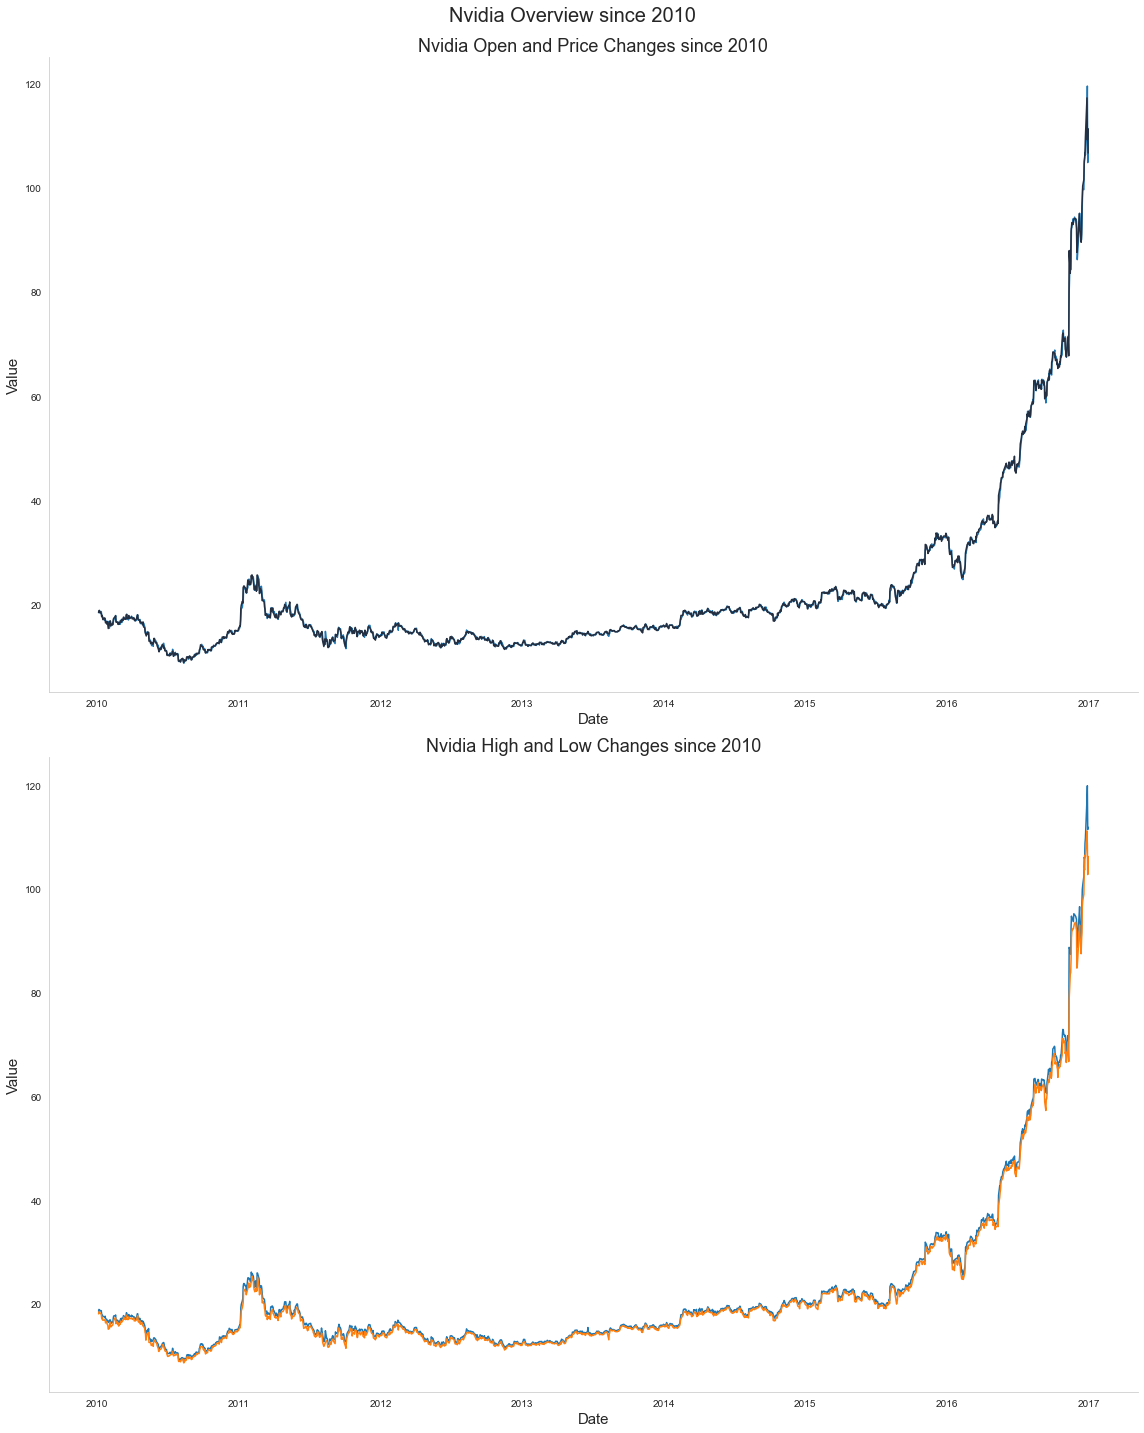

In [15]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
colors2 = ['#F80000','#242F41']

fig, (ax4, ax5) = plt.subplots(2, 1,figsize=(16,20))
fig.suptitle("Nvidia Overview since 2010", fontsize=20, verticalalignment="bottom")
 
#Plot 1
ax4=sns.lineplot(data=NVDA, x='date',y='open',ax=ax4)
ax4=sns.lineplot(data=NVDA, x='date',y='close',ax=ax4, color=colors2[1])
ax4.set_ylabel('Value',fontsize=15,fontweight='normal')    
ax4.set_xlabel('Date',fontsize=15,fontweight='normal') 
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.set_title('Nvidia Open and Price Changes since 2010',fontsize=18, fontweight='normal')

#Plot 2
ax5=sns.lineplot(data=NVDA, x='date',y='high',ax=ax5)
ax5=sns.lineplot(data=NVDA, x='date',y='low',ax=ax5)
ax5.set_ylabel('Value',fontsize=15,fontweight='normal')    
ax5.set_xlabel('Date',fontsize=15,fontweight='normal') 
ax5.spines['right'].set_visible(False)
ax5.spines['top'].set_visible(False)
ax5.set_title('Nvidia High and Low Changes since 2010',fontsize=18, fontweight='normal')

plt.tight_layout()

Text(0.5, 1.0, 'Nvidia Volume Changes since 2010')

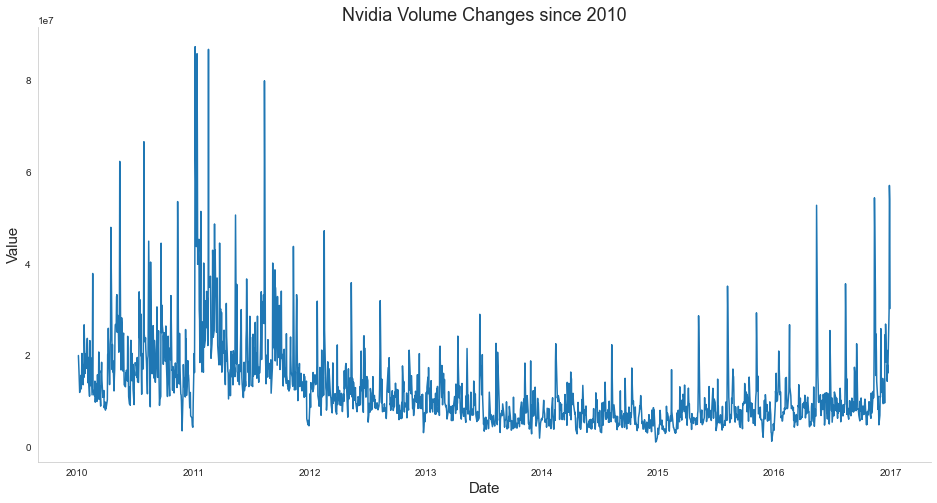

In [16]:
fig6=plt.figure(figsize=(16,8))
ax6=sns.lineplot(data=NVDA, x='date',y='volume')
ax6.set_ylabel('Value',fontsize=15,fontweight='normal')    
ax6.set_xlabel('Date',fontsize=15,fontweight='normal') 
ax6.spines['right'].set_visible(False)
ax6.spines['top'].set_visible(False)
ax6.set_title('Nvidia Volume Changes since 2010',fontsize=18, fontweight='normal')

### NVIDIA Numerical Feature Plot

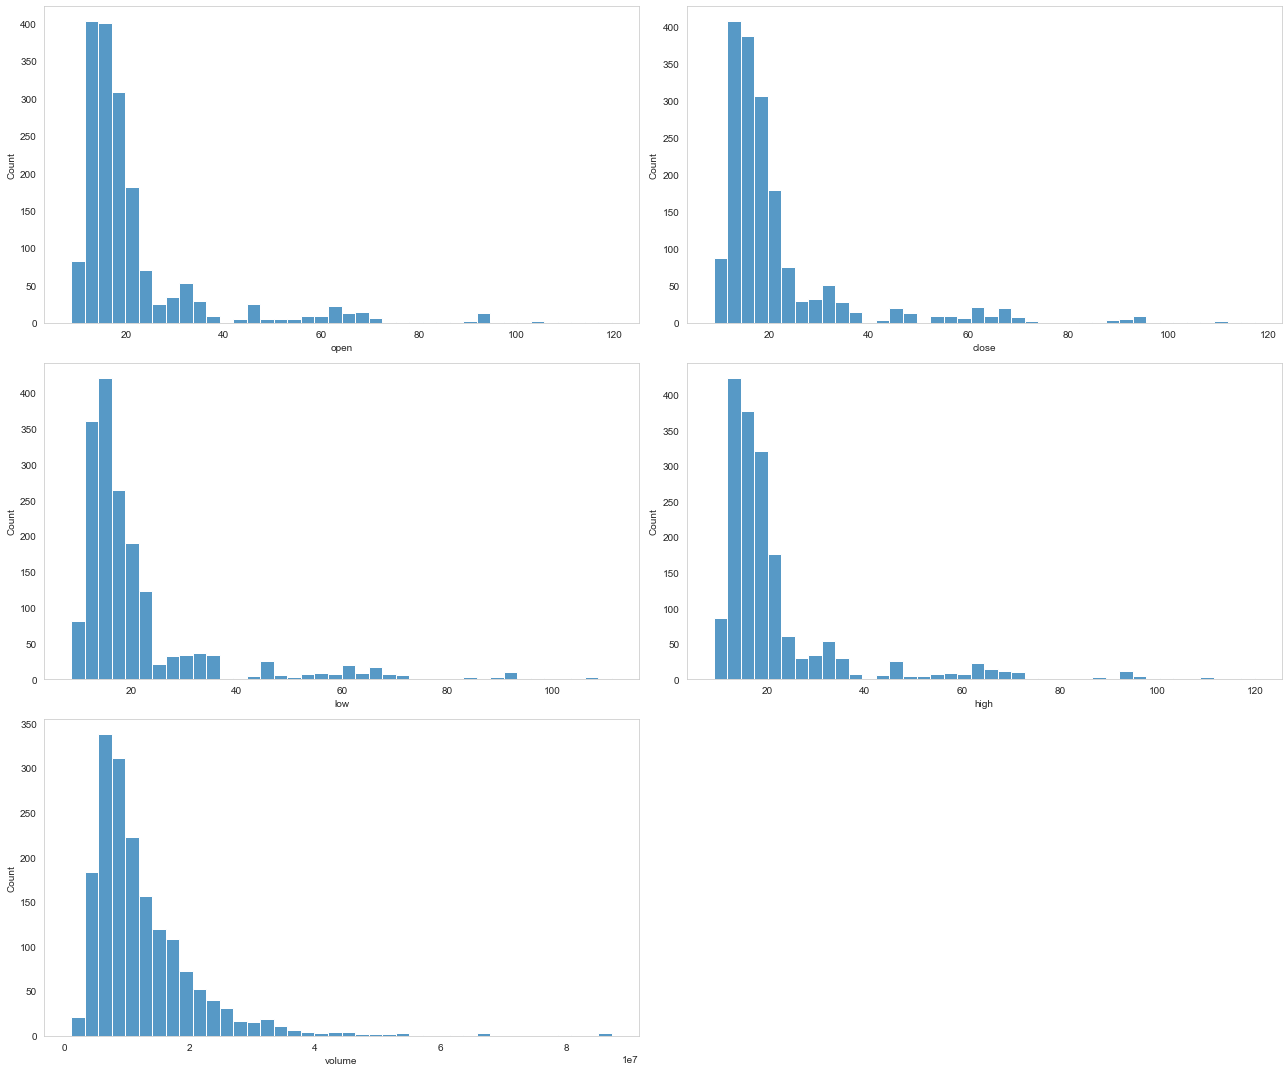

In [17]:
NVDA_num = NVDA[['open','close','low','high','volume']]

plt.figure(figsize=(18, 15))
for i in range(0, len(list(NVDA_num))):
    plt.subplot(3, 2, i+1)
    sns.histplot(x=NVDA[list(NVDA_num)[i]],bins = 40)
    plt.tight_layout()

### NVIDIA Outliers Checking

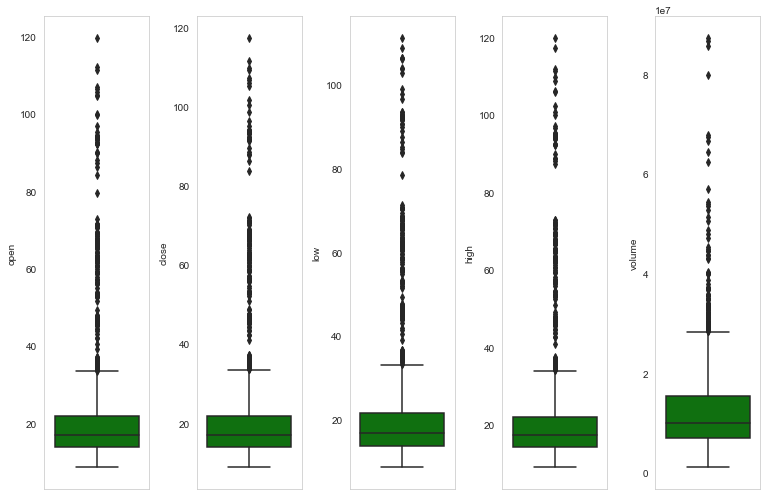

In [18]:
plt.figure(figsize=(15, 7))
for i in range(0, len(list(NVDA_num))):
    plt.subplot(1, 7, i+1)
    sns.boxplot(y=NVDA[list(NVDA_num)[i]],color='green',orient='v')
    plt.tight_layout()

### Time Series Stationary Checking

### Amazon

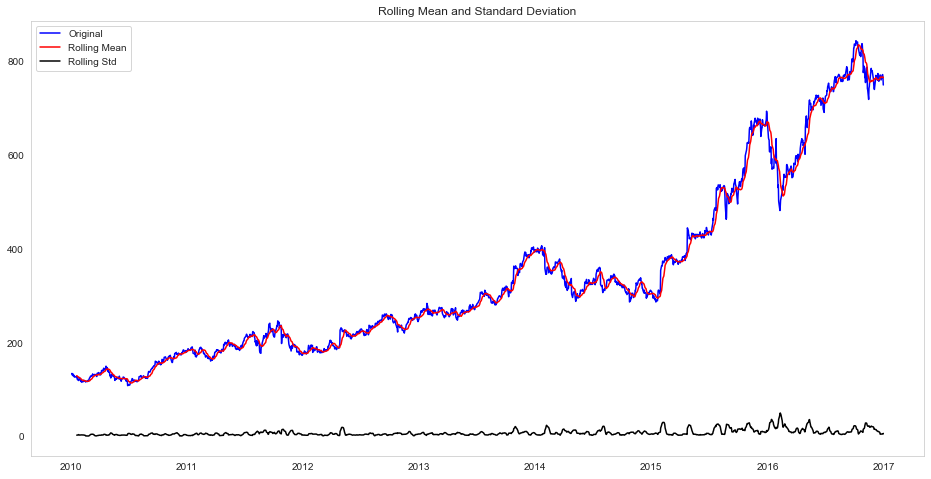

Results of dickey fuller test
Test Statistics                   0.495121
p-value                           0.984724
No. of lags used                  4.000000
Number of observations used    1757.000000
critical value (1%)              -3.434077
critical value (5%)              -2.863186
critical value (10%)             -2.567646
dtype: float64


In [19]:
# Setting Date as Index
AMZN_date_index = AMZN.set_index('date')

# Test for staionarity
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    #Plot rolling statistics:
    plt.figure(figsize=(16,8))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(AMZN_date_index['close'])

### NVIDIA

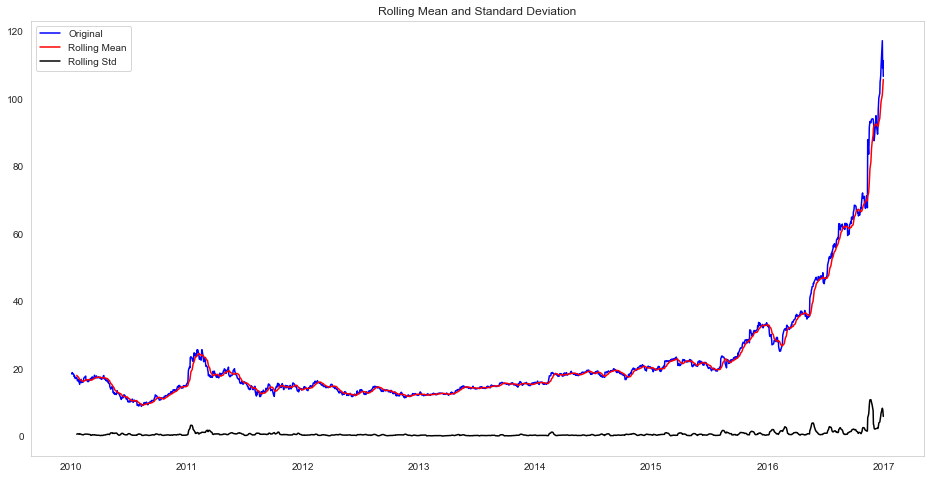

Results of dickey fuller test
Test Statistics                   5.654739
p-value                           1.000000
No. of lags used                 23.000000
Number of observations used    1738.000000
critical value (1%)              -3.434118
critical value (5%)              -2.863204
critical value (10%)             -2.567656
dtype: float64


In [20]:
# Setting Date as Index
NVDA_date_index = NVDA.set_index('date')

# Test for staionarity
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    #Plot rolling statistics:
    plt.figure(figsize=(16,8))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(NVDA_date_index['close'])

### Time Series Decomposition

### Amazon 

### Multiplicative 

<Figure size 432x288 with 0 Axes>

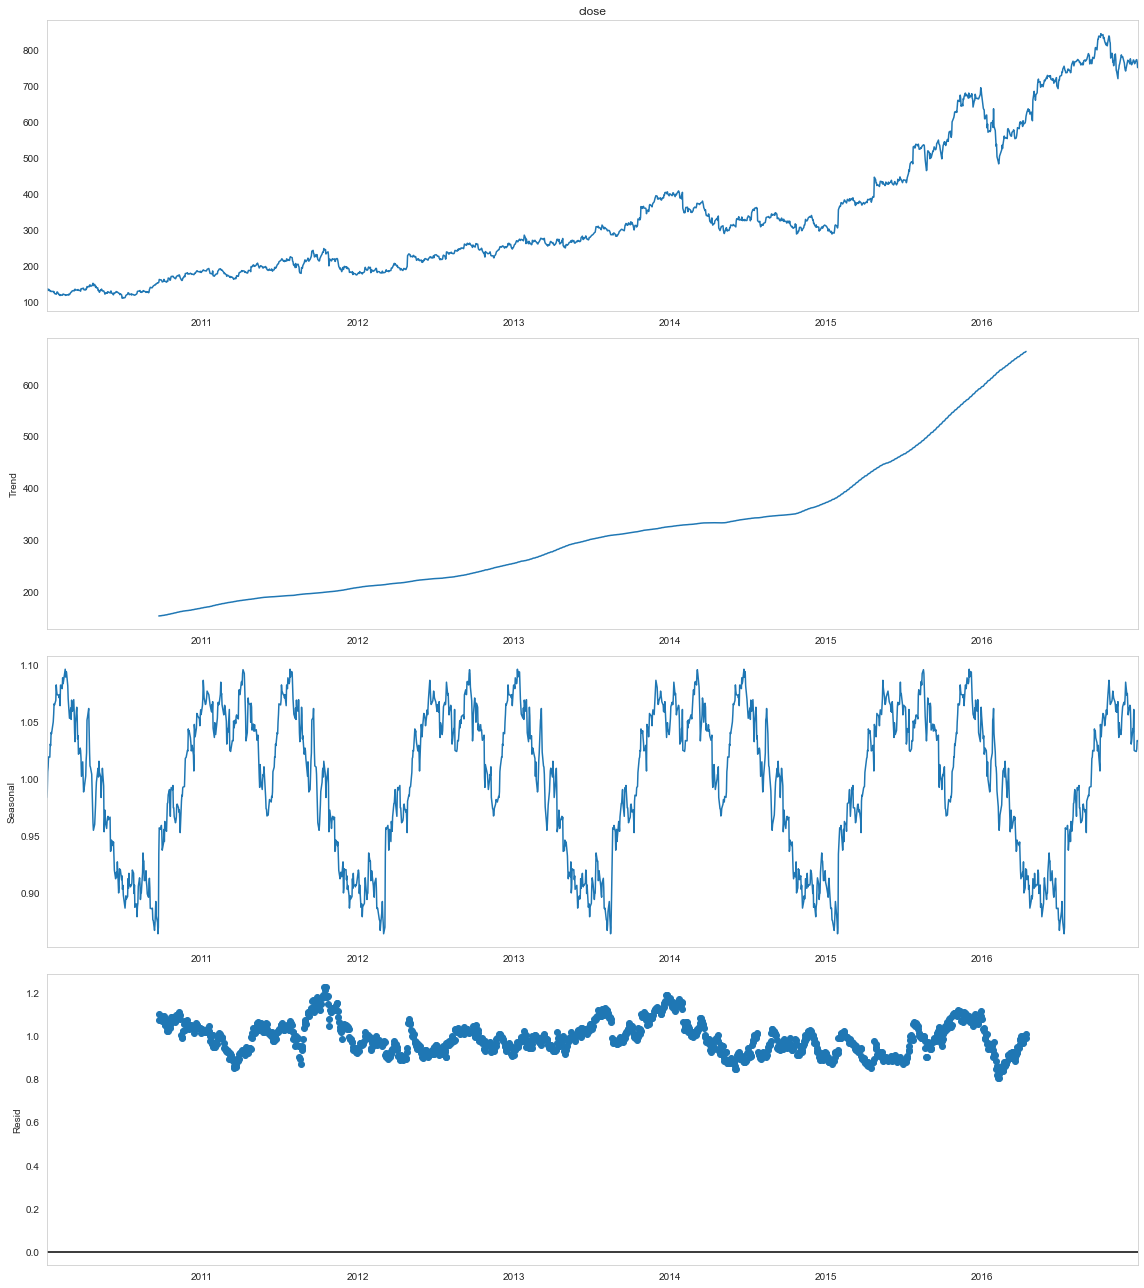

In [21]:
result1 = seasonal_decompose(AMZN_date_index['close'], model='multiplicative', period = 365)
fig = plt.figure()  
fig = result1.plot()  
fig.set_size_inches(16,18)
plt.tight_layout()

### Additive

In [ ]:
result2 = seasonal_decompose(AMZN_date_index['close'], model='additive', period = 365)
fig = plt.figure()  
fig = result2.plot()  
fig.set_size_inches(16,18)
plt.tight_layout()

### NVIDIA

### Multiplicative

<Figure size 432x288 with 0 Axes>

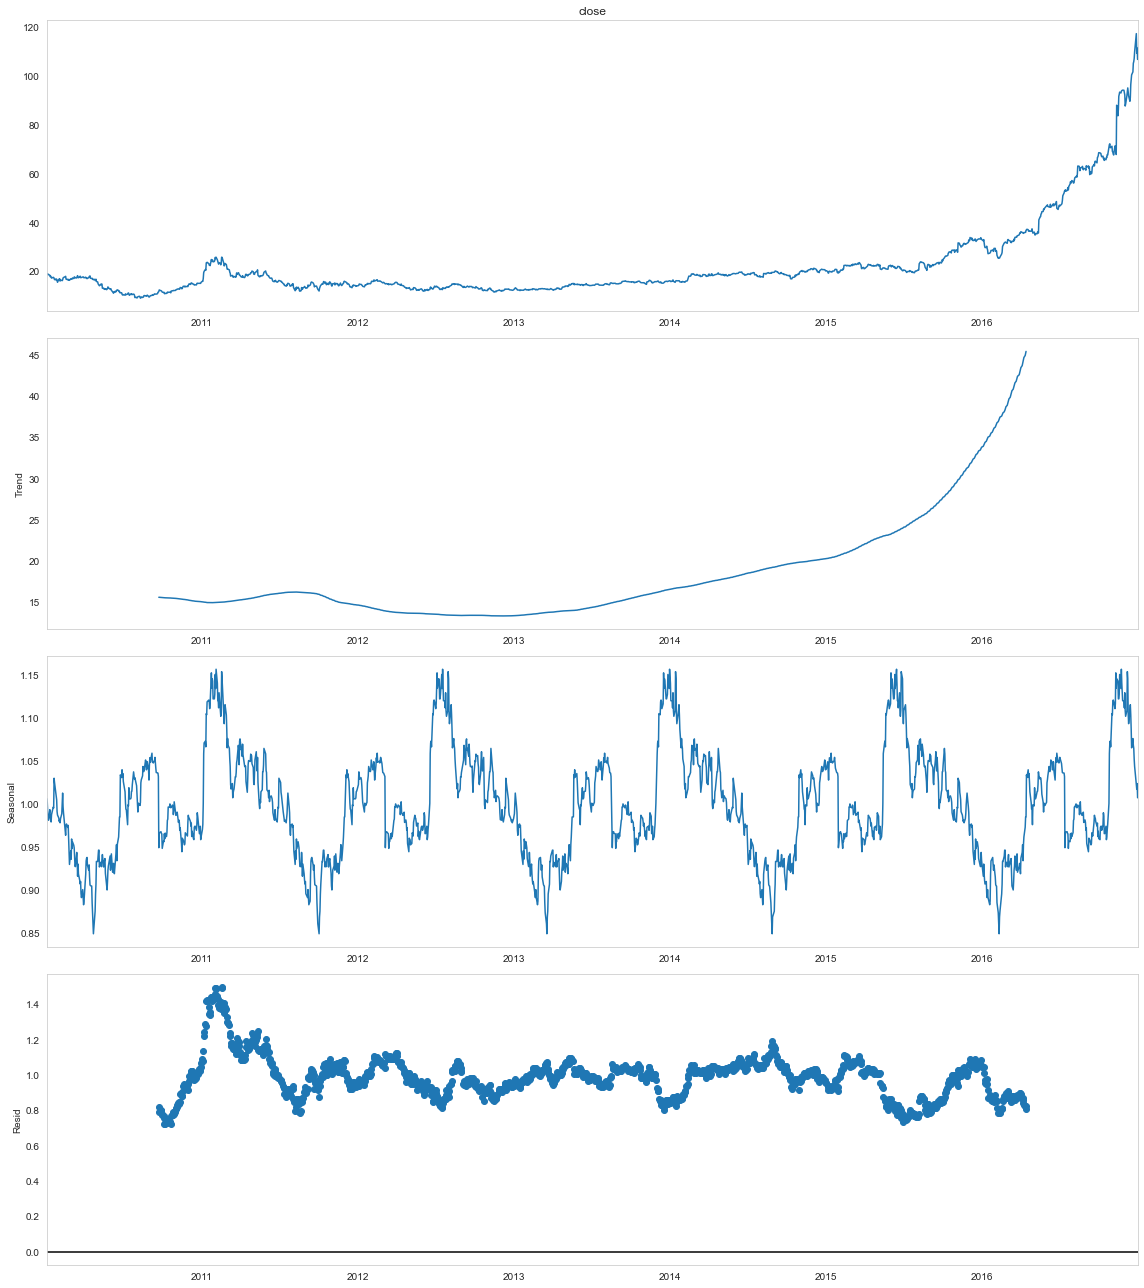

In [22]:
result3 = seasonal_decompose(NVDA_date_index['close'], model='multiplicative', period = 365)
fig = plt.figure()  
fig = result3.plot()  
fig.set_size_inches(16,18)
plt.tight_layout()

### Additive

In [ ]:
result4 = seasonal_decompose(NVDA_date_index['close'], model='additive', period = 365)
fig = plt.figure()  
fig = result4.plot()  
fig.set_size_inches(16,18)
plt.tight_layout()

### Preparing Dataset for Model Forecasting

### Splitting Each Dataset to Train and Test Set

### Amazon

No handles with labels found to put in legend.


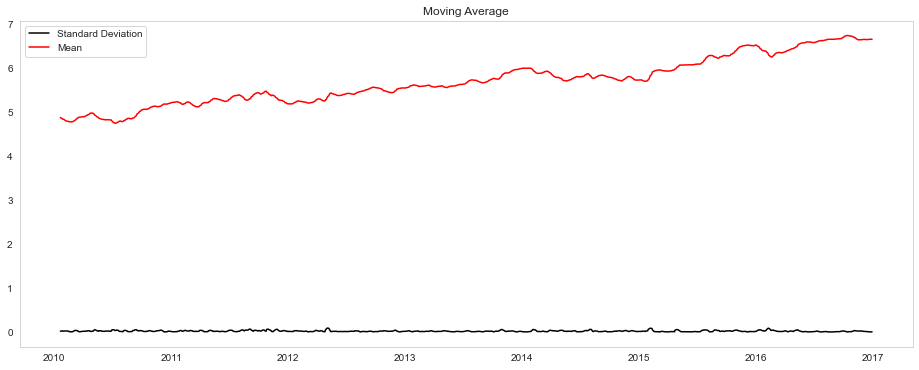

In [23]:
# If not stationary then eliminate trend
# Eliminate trend
from pylab import rcParams
AMZN_log = np.log(AMZN_date_index['close'])
moving_avg = AMZN_log.rolling(12).mean()
std_dev = AMZN_log.rolling(12).std()

plt.figure(figsize=(16,6))
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

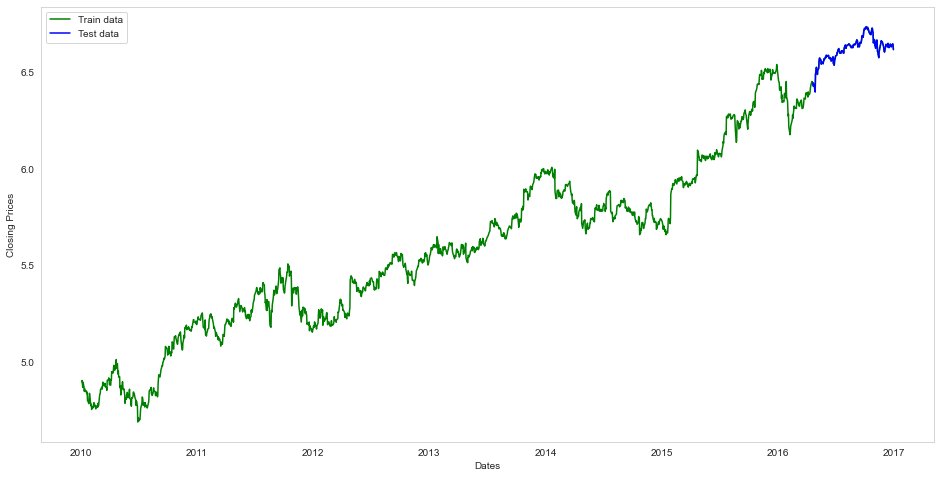

In [24]:
# Split data into Train and Training set
train_data1, test_data1 = AMZN_log[5:int(len(AMZN_log)*0.9)], AMZN_log[int(len(AMZN_log)*0.9):]
plt.figure(figsize=(16,8))
###plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(AMZN_log, 'green', label='Train data')
plt.plot(test_data1, 'blue', label='Test data')
plt.legend()

### NVIDIA

No handles with labels found to put in legend.


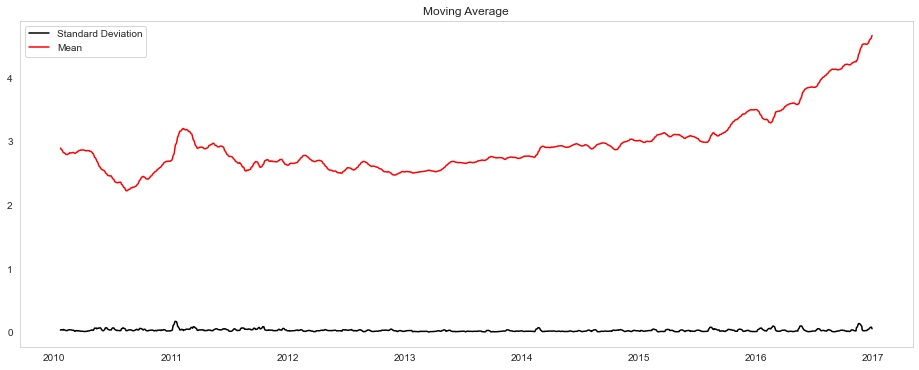

In [25]:
# If not stationary then eliminate trend
# Eliminate trend
from pylab import rcParams
NVDA_log = np.log(NVDA_date_index['close'])
moving_avg2 = NVDA_log.rolling(12).mean()
std_dev2 = NVDA_log.rolling(12).std()

plt.figure(figsize=(16,6))
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev2, color ="black", label = "Standard Deviation")
plt.plot(moving_avg2, color="red", label = "Mean")
plt.legend()
plt.show()

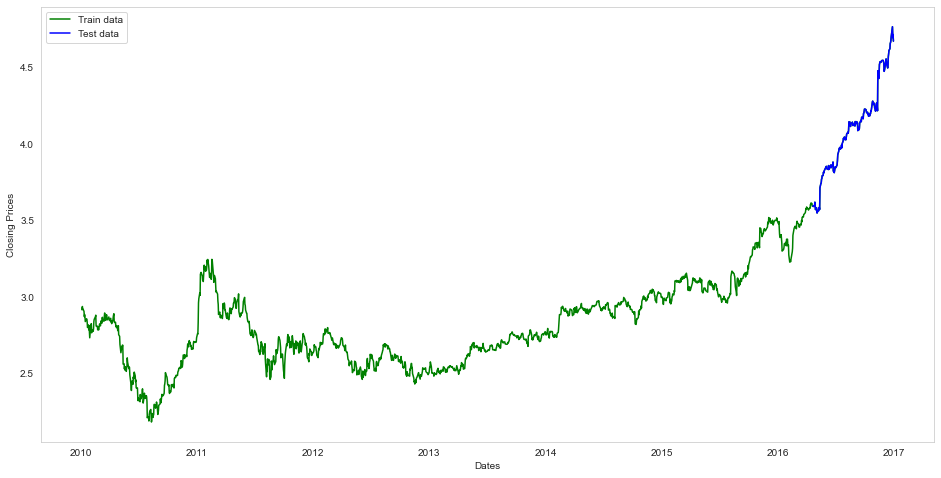

In [26]:
# Split data into Train and Training set
train_data2, test_data2 = NVDA_log[5:int(len(NVDA_log)*0.9)], NVDA_log[int(len(NVDA_log)*0.9):]
plt.figure(figsize=(16,8))
###plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(NVDA_log, 'green', label='Train data')
plt.plot(test_data2, 'blue', label='Test data')
plt.legend()

### Creating Auto ARIMA Model

### Amazon

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=4.88 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-4534.285, Time=0.45 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-8007.090, Time=2.34 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-6094.969, Time=2.86 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-4478.158, Time=0.09 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-7472.720, Time=0.46 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-8213.491, Time=8.52 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=11.50 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=6.76 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=-4548.015, Time=2.12 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=-8211.575, Time=8.97 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=-8210.547, Time=9.62 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=-6092.608, Time=5.55 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=-8164.691, Time=10.34 sec
 ARIMA(1,0,0)(2,1,0)[

C:\Users\GIGABYTE\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


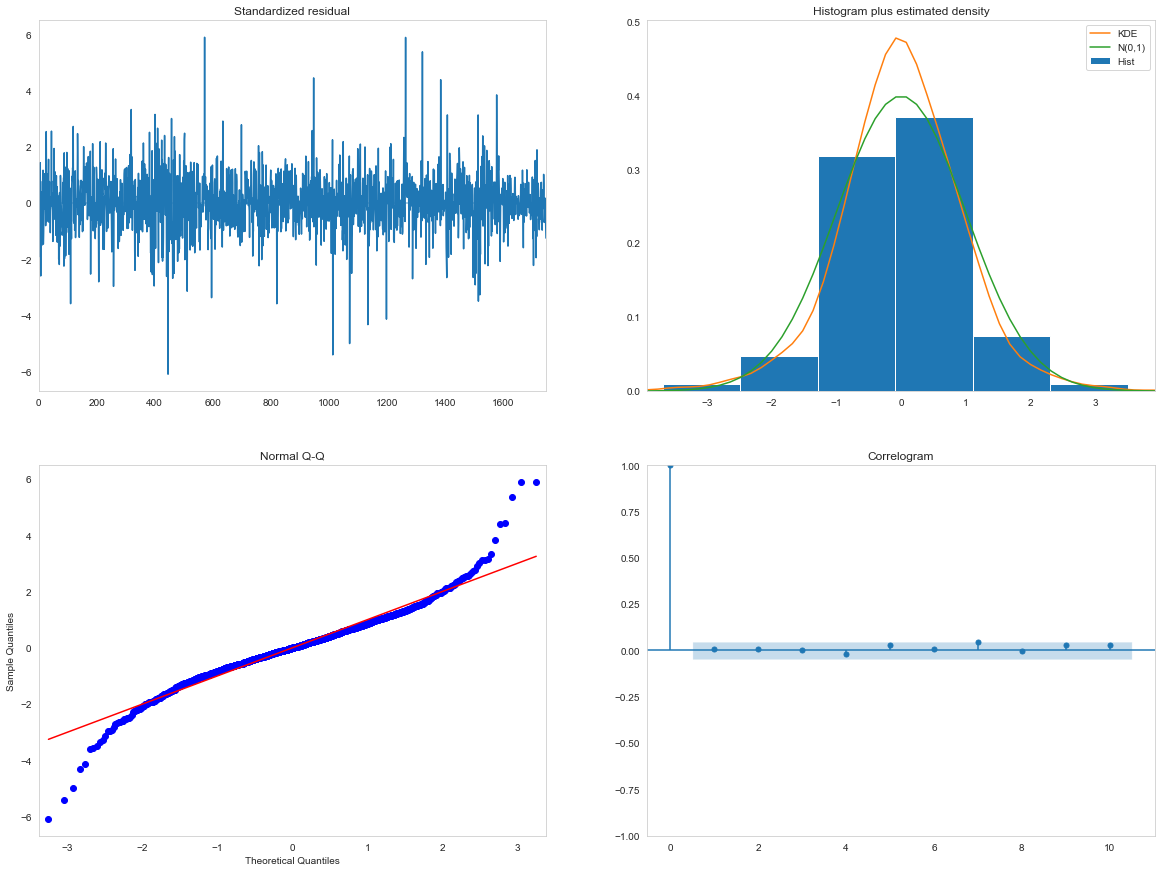

In [36]:
smodel = pm.auto_arima(AMZN_log, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)


print(smodel.summary())
smodel.plot_diagnostics(figsize=(20,15))
plt.show()

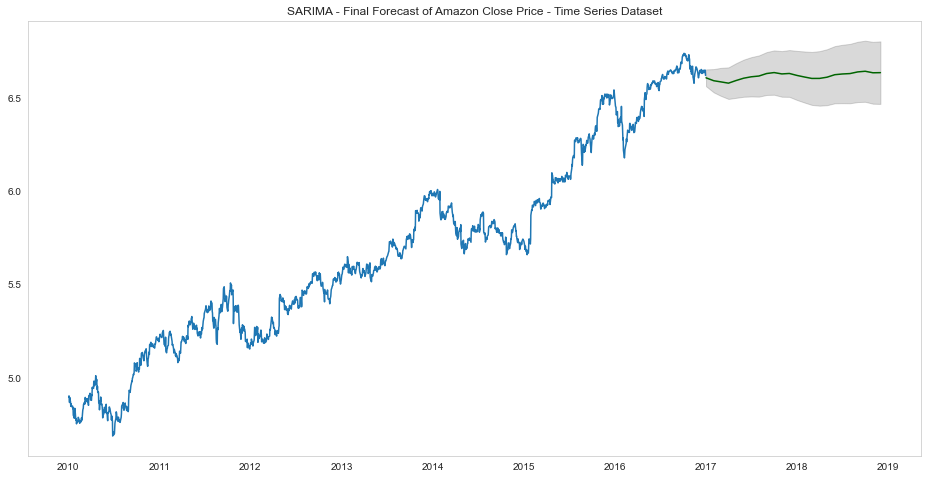

In [40]:
# Forecast
n_periods = 24
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(AMZN_log.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(16,8))
plt.plot(AMZN_log)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of Amazon Close Price - Time Series Dataset")
plt.show()

### NVIDIA

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=5.43 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-3701.453, Time=0.36 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-7399.624, Time=2.84 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-5214.071, Time=2.99 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-3667.335, Time=0.21 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-6849.434, Time=0.72 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-7586.224, Time=8.05 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=12.59 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=5.89 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=-3725.406, Time=2.69 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=-7584.201, Time=9.69 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=-7584.192, Time=9.14 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=-5222.684, Time=5.86 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=-7575.609, Time=10.47 sec
 ARIMA(1,0,0)(2,1,0)[

C:\Users\GIGABYTE\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


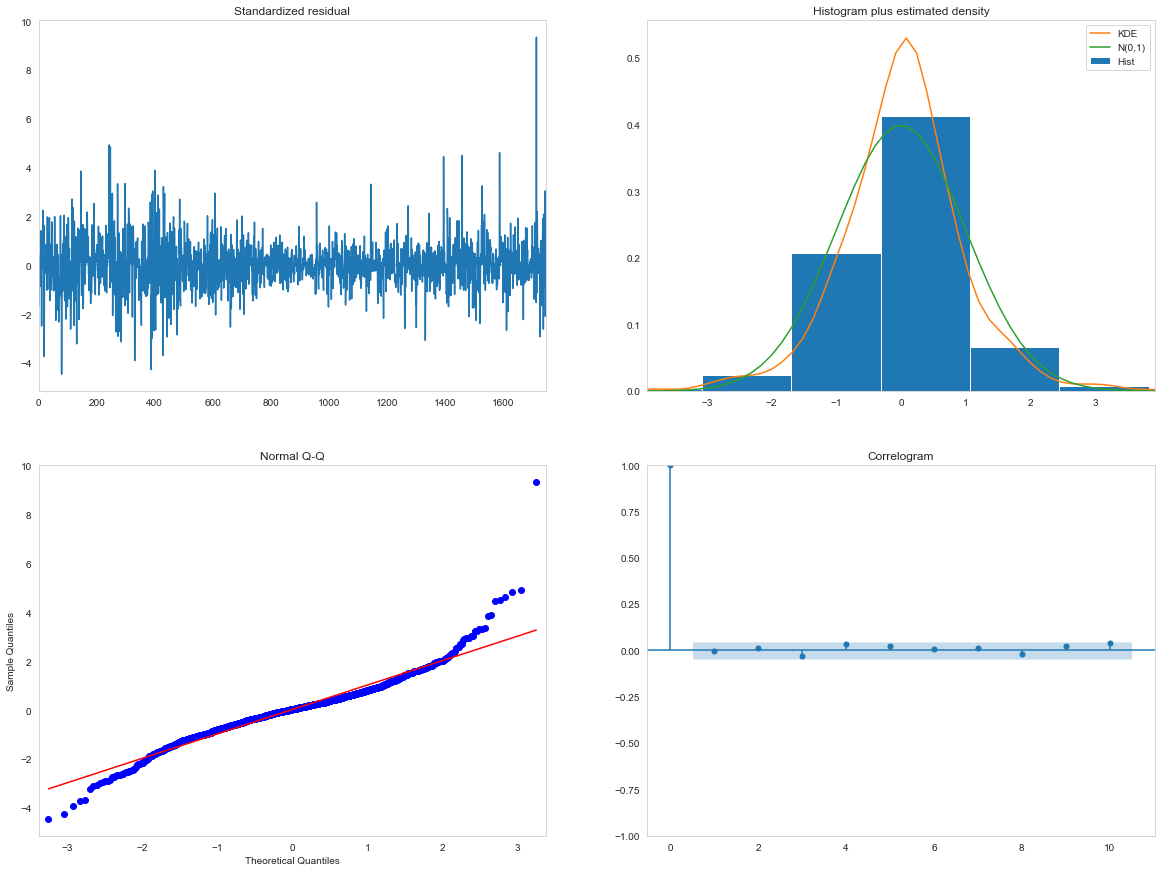

In [37]:
smodel2 = pm.auto_arima(NVDA_log, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)


print(smodel2.summary())
smodel2.plot_diagnostics(figsize=(20,15))
plt.show()

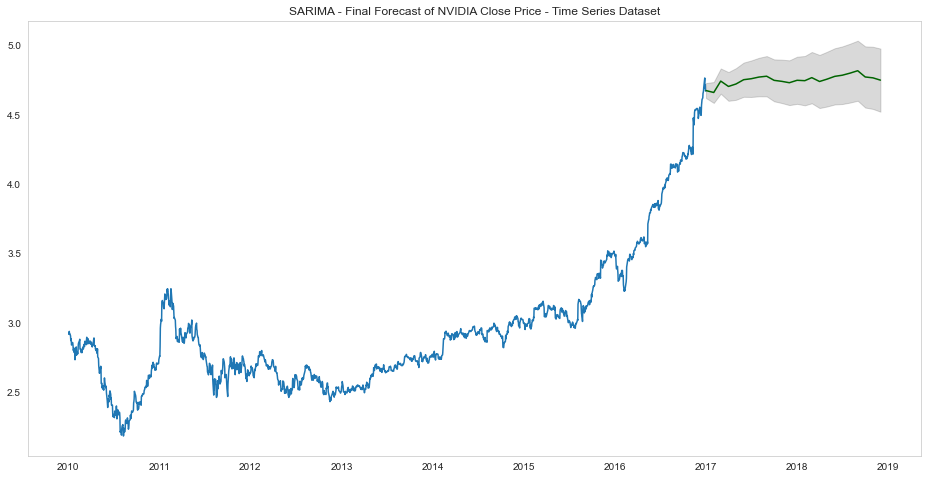

In [42]:
# Forecast
n_periods = 24
fitted2, confint = smodel2.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc2 = pd.date_range(NVDA_log.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series2 = pd.Series(fitted2, index=index_of_fc2)
lower_series2 = pd.Series(confint[:, 0], index=index_of_fc2)
upper_series2 = pd.Series(confint[:, 1], index=index_of_fc2)

# Plot
plt.figure(figsize=(16,8))
plt.plot(NVDA_log)
plt.plot(fitted_series2, color='darkgreen')
plt.fill_between(lower_series2.index, 
                 lower_series2, 
                 upper_series2, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of NVIDIA Close Price - Time Series Dataset")
plt.show()

### FBProphet Model

### Selecting and Renaming Dataset To Fit FBProphet Model

In [28]:
# Amazon
amzn_p = AMZN[['date','close']]
amzn_p.columns=['ds','y']

# NVIDIA
nvda_p = NVDA[['date','close']]
nvda_p.columns=['ds','y']

# set the uncertainty interval to 95% (the Prophet default is 80%)
prophet = Prophet(interval_width=0.95)

### Fitting FBProphet Model To Dataset

### Amazon

In [ ]:
prophet.fit(amzn_p)

### Making Future Data For Forecasting

### Amazon

In [ ]:
future_amzn_dates = prophet.make_future_dataframe(periods=36, freq='MS')
future_amzn_dates.tail()

### FBProphet Forecasting

### Amazon

In [ ]:
forecast = prophet.predict(future_amzn_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

In [ ]:
prophet.plot(forecast, uncertainty=True)

In [ ]:
prophet.plot_components(forecast)

### Fitting FBProphet Model To Dataset

### NVIDIA

In [29]:
prophet.fit(nvda_p)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Making Future Data For Forecasting

### NVIDIA

In [30]:
future_nvda_dates = prophet.make_future_dataframe(periods=36, freq='MS')
future_nvda_dates.tail()

,ds
1793,2019-08-01
1794,2019-09-01
1795,2019-10-01
1796,2019-11-01
1797,2019-12-01


### FBProphet Forecasting 

### NVIDIA

In [32]:
forecast = prophet.predict(future_nvda_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2010-01-04,19.706245,11.692301,27.376671
1,2010-01-05,19.540565,11.066710,28.263035
2,2010-01-06,19.280571,10.951683,27.361525
3,2010-01-07,19.020546,10.246548,27.570731
4,2010-01-08,18.802228,10.906946,27.171821


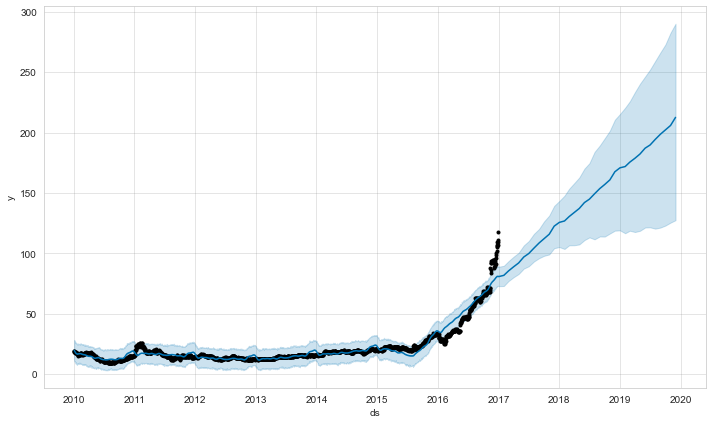

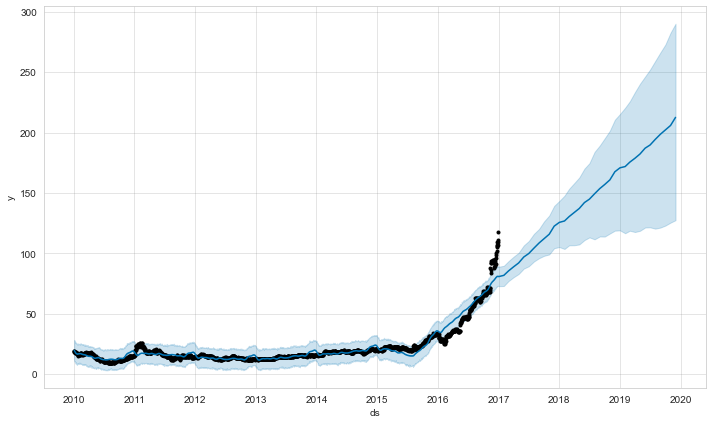

In [33]:
prophet.plot(forecast, uncertainty=True)

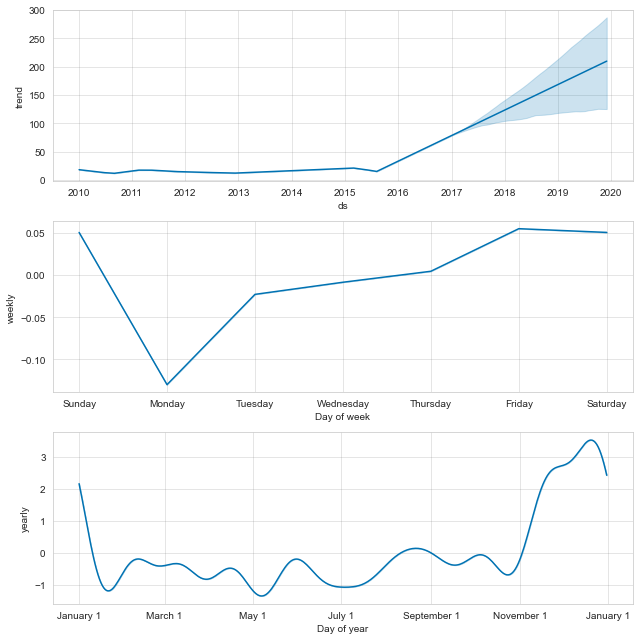

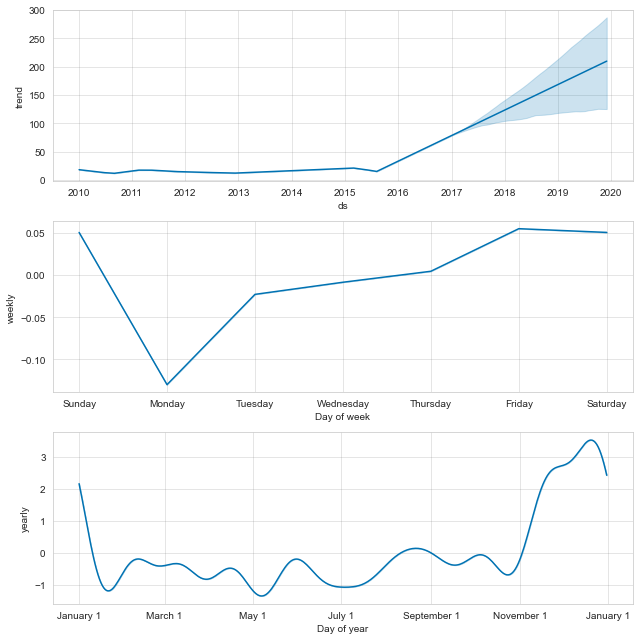

In [34]:
prophet.plot_components(forecast)